In [ ]:
# @title Install Required Libraries
!pip install imbalanced-learn xgboost lightgbm shap tensorflow


In [ ]:
# @title Import Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# NLP & ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Imbalance handling
from imblearn.over_sampling import BorderlineSMOTE

# Models
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgb

# Explainable AI
import shap


In [ ]:
# @title Load Dataset
from google.colab import files
files.upload()
file_path = "suicidal_ideation_reddit_annotated.csv"
df = pd.read_csv(file_path)
df.head()



Saving suicidal_ideation_reddit_annotated.csv to suicidal_ideation_reddit_annotated (2).csv


,usertext,label
0,I just want to end my life so badly. My life i...,1
1,"My relationship is complicated and painful, bu...",1
2,"I owe a lot of money , so I have to work.The c...",1
3,On the 2 of October I overdosed I just felt so...,1
4,"Everyone tells me how wonderful I am, but not ...",1


In [ ]:
# @title le = LabelEncoder()
from sklearn.preprocessing import LabelEncoder

# create LabelEncoder instance
le = LabelEncoder()

# encode the labels
df['label'] = le.fit_transform(df['label'])

# separate features and target
X = df['usertext']
y = df['label']


In [ ]:
# @title TF-IDF Feature Extraction

# Drop rows where text is NaN
df.dropna(subset=['usertext'], inplace=True)

X = df['usertext']
y = df['label']

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(X)


In [ ]:
# @title Train–Test Split
# Keep only required columns
df = df[['usertext', 'label']]

# Remove rows with missing text or label
df.dropna(subset=['usertext', 'label'], inplace=True)

# Reset index (VERY important)
df.reset_index(drop=True, inplace=True)

print(df.shape)  # sanity check


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['label'])

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(df['usertext'])


print(X_tfidf.shape[0], len(y))


(12615, 2)
12615 12615


In [ ]:
# @title Handle Data Imbalance — Borderline-SMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
accuracy_dict = {}


In [ ]:
# @title Model 1 — Multinomial Naïve Bayes
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)

y_pred_nb = nb.predict(X_test)

accuracy_dict['Naive Bayes'] = accuracy_score(y_test, y_pred_nb)

print("Naive Bayes Accuracy:", accuracy_dict['Naive Bayes'])
print(classification_report(y_test, y_pred_nb))


In [ ]:
#@title Model 2 — XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train_res, y_train_res)

y_pred_xgb = xgb.predict(X_test)

accuracy_dict['XGBoost'] = accuracy_score(y_test, y_pred_xgb)

print("XGBoost Accuracy:", accuracy_dict['XGBoost'])
print(classification_report(y_test, y_pred_xgb))


In [ ]:
#@title Model 3 — LightGBM
lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

lgbm.fit(X_train_res, y_train_res)

y_pred_lgbm = lgbm.predict(X_test)

accuracy_dict['LightGBM'] = accuracy_score(y_test, y_pred_lgbm)

print("LightGBM Accuracy:", accuracy_dict['LightGBM'])
print(classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 4597, number of negative: 4597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.464595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113821
[LightGBM] [Info] Number of data points in the train set: 9194, number of used features: 2918
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.8689564068692206
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1814
           1       0.87      0.88      0.87      1971

    accuracy                           0.87      3785
   macro avg       0.87      0.87      0.87      3785
weighted avg       0.87      0.87      0.87      3785



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# @title ACCURACY COMPARISON TABLE (Paper-Ready)
accuracy_df = pd.DataFrame.from_dict(
    accuracy_dict, orient='index', columns=['Accuracy']
)

accuracy_df


,Accuracy
Naive Bayes,0.851519
XGBoost,0.875561
LightGBM,0.868956


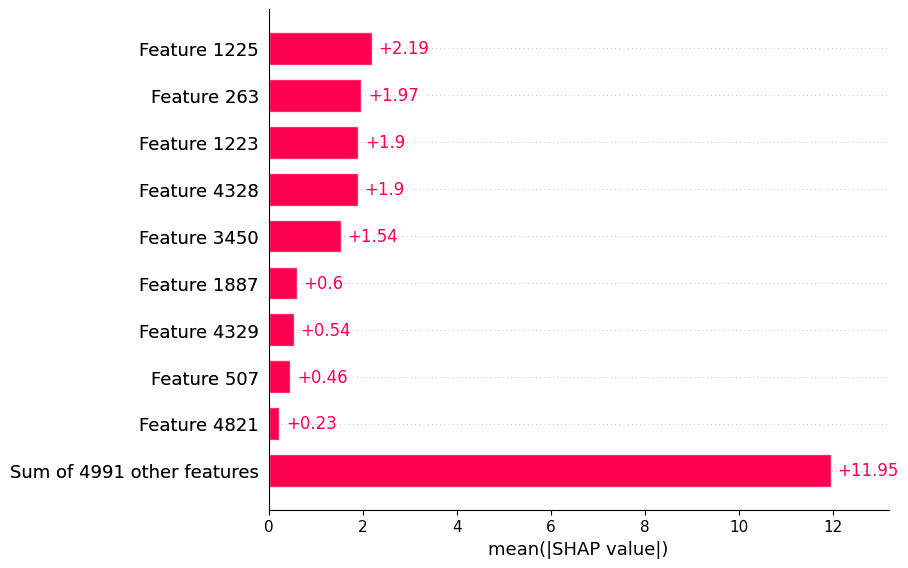

In [ ]:
#@title SHAP for XGBoost

import shap

# Dense conversion (limited samples)
X_test_dense = X_test.toarray()[:200]

# NEW API: call explainer directly
explainer = shap.TreeExplainer(xgb)
shap_exp = explainer(X_test_dense)

# Bar plot (global importance)
shap.plots.bar(shap_exp)



/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


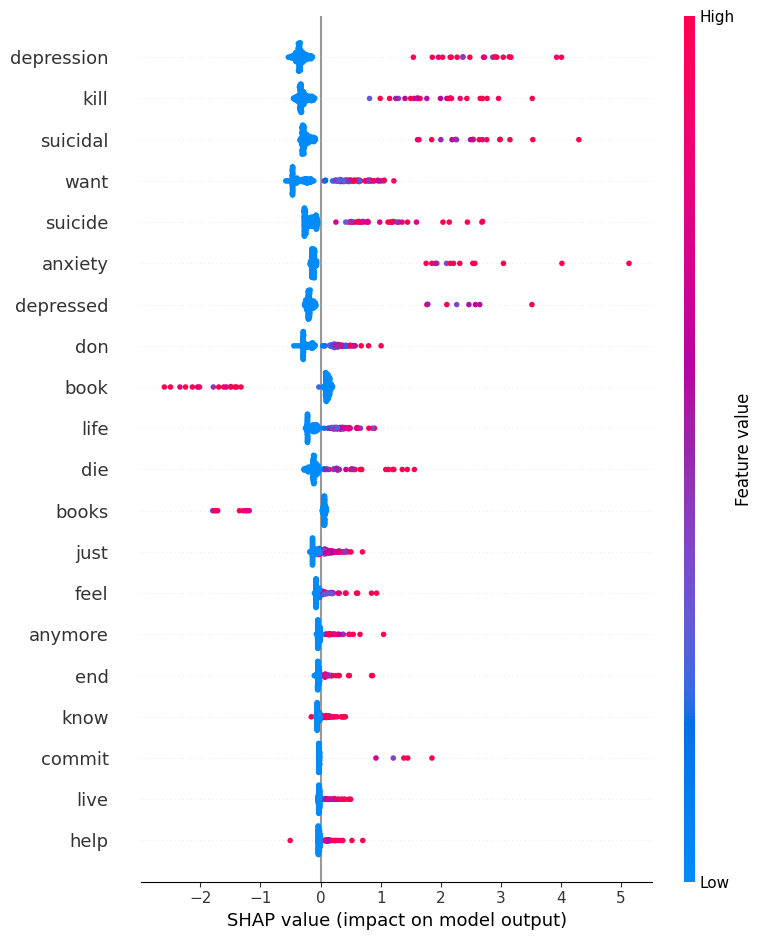

In [ ]:
# @title SHAP for LightGBM
import shap
import numpy as np

# Convert sparse matrices to dense (LIMITED samples)
X_train_dense = X_train_res.toarray()
X_test_dense = X_test.toarray()

# Ensure numeric dtype (very important!)
X_train_dense = X_train_dense.astype(np.float32)
X_test_dense = X_test_dense.astype(np.float32)

# Use TreeExplainer explicitly
explainer_lgbm = shap.TreeExplainer(lgbm)

# Compute SHAP values (small subset)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_dense[:200])

# Plot global importance
shap.summary_plot(
    shap_values_lgbm,
    X_test_dense[:200],
    feature_names=tfidf.get_feature_names_out()
)


In [ ]:
# @ tittle IMPORT REQUIRED METRICS
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc


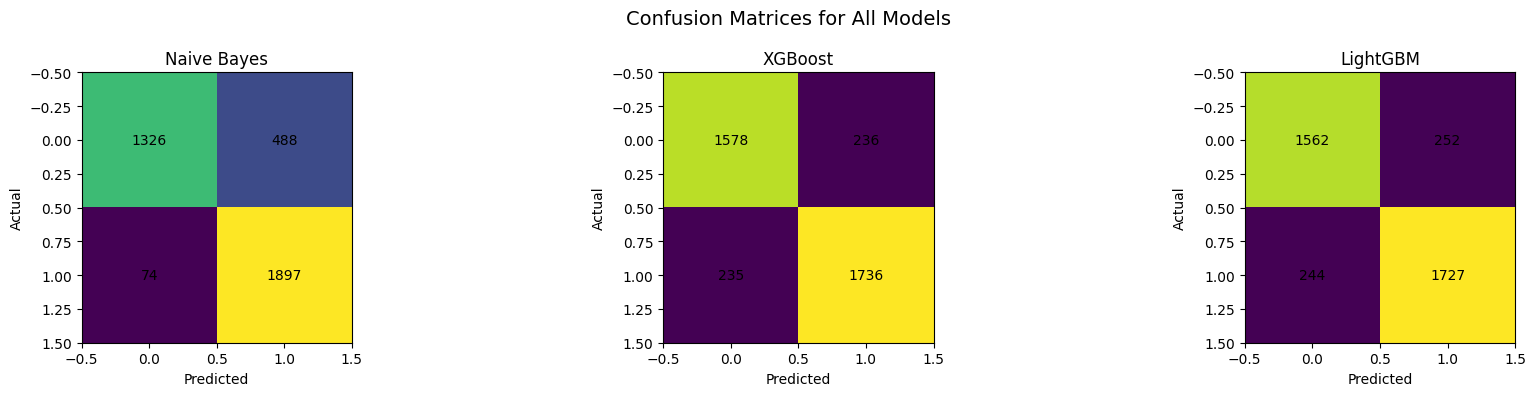

In [ ]:
# @ tittle CONFUSION MATRIX (CF Matrix)
def plot_all_confusion_matrices(y_test, predictions, model_names):
    fig, axes = plt.subplots(1, len(predictions), figsize=(18, 4))

    for ax, y_pred, name in zip(axes, predictions, model_names):
        cm = confusion_matrix(y_test, y_pred)
        ax.imshow(cm)
        ax.set_title(name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, cm[i, j], ha="center", va="center")

    plt.suptitle("Confusion Matrices for All Models", fontsize=14)
    plt.tight_layout()
    plt.show()

predictions = [
    y_pred_nb,
    y_pred_xgb,
    y_pred_lgbm
]

model_names = [
    "Naive Bayes",
    "XGBoost",
    "LightGBM"
]

plot_all_confusion_matrices(y_test, predictions, model_names)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:54:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 4597, number of negative: 4597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113821
[LightGBM] [Info] Number of data points in the train set: 9194, number of used features: 2918
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


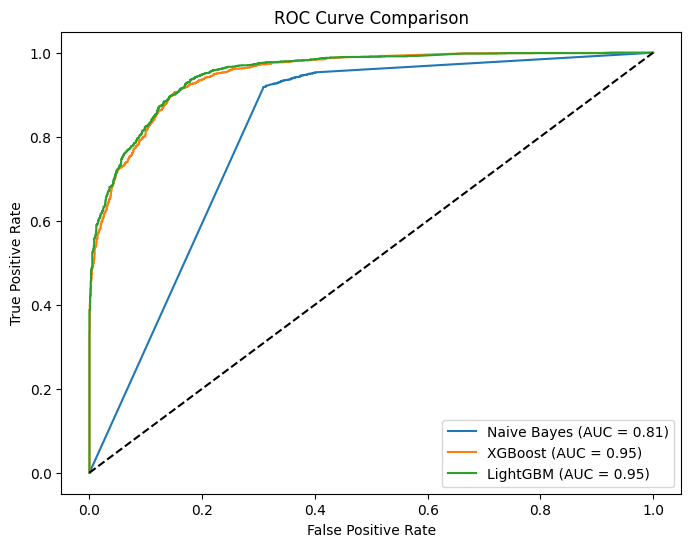

In [ ]:
#  @ title ROC CURVE

# Convert to dense for Naive Bayes
X_train_nb = X_train_res.toarray() if hasattr(X_train_res, "toarray") else X_train_res
X_test_nb = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# --- Train GaussianNB ---
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_res)

# --- Train XGBoost ---
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)

# --- Train LightGBM ---
import lightgbm as lgb
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train_res, y_train_res)

# ===========================
#  Predict Probabilities
# ===========================
y_prob_nb = nb_model.predict_proba(X_test_nb)[:, 1]  # dense required
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]   # sparse/dense ok
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1] # sparse/dense ok

# ===========================
# ROC Curve
# ===========================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

probabilities = {
    "Naive Bayes": y_prob_nb,
    "XGBoost": y_prob_xgb,
    "LightGBM": y_prob_lgbm
}

plt.figure(figsize=(8,6))
for name, probs in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


Saving suicidal_ideation_reddit_annotated.csv to suicidal_ideation_reddit_annotated (2).csv
                                             usertext  label predicted_method
0   I just want to end my life so badly. My life i...      1        car_crash
1   My relationship is complicated and painful, bu...      1          unknown
2   I owe a lot of money , so I have to work.The c...      1          unknown
3   On the 2 of October I overdosed I just felt so...      1           poison
4   Everyone tells me how wonderful I am, but not ...      1          unknown
5   My last words before my death,For whoever is i...      1          unknown
6   I have been struggling for 2 months now with s...      1          hanging
7   I had some extremely horrible violent stuff ha...      1        car_crash
8   This past month has been the worst. 3 1/2 week...      1          hanging
9   Hello I am 16 years old and I want to kill mys...      1          unknown
10  Abusive dad. Bullying. Being a wimp because I 

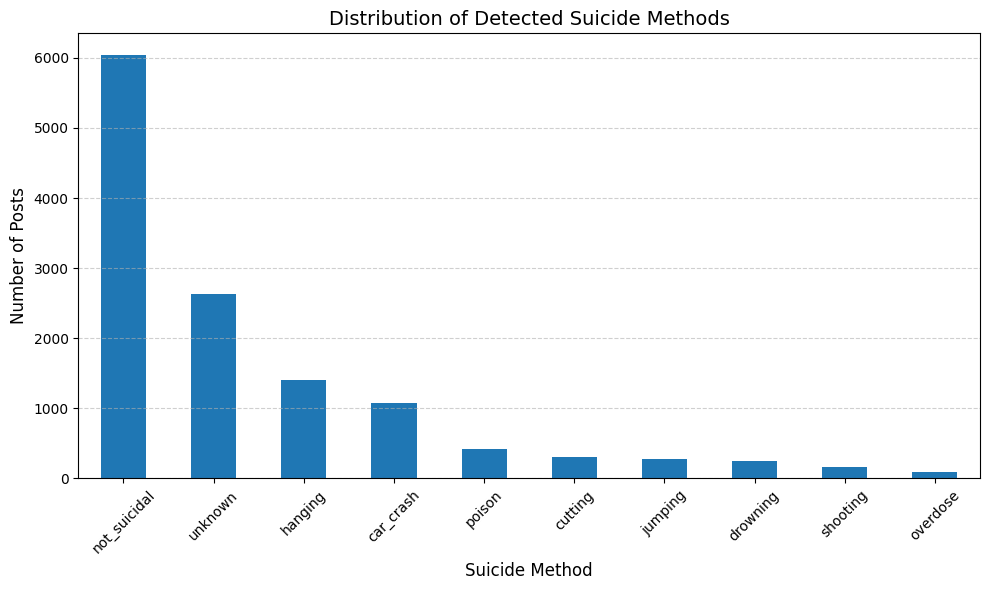

In [ ]:
#@title Suicide Method Detection Model (Phase 2)
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load Dataset
from google.colab import files
files.upload()
file_path = "suicidal_ideation_reddit_annotated.csv"
df = pd.read_csv(file_path)
df.head()

# Step 4: Clean Text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean_text"] = df["usertext"].apply(clean_text)

# Suicide method keywords
suicide_methods = {
    "hanging": ["hang", "rope", "neck", "ceiling", "fan"],
    "jumping": ["jump", "bridge", "roof", "building", "cliff"],
    "poison": ["poison", "acid", "toxic", "pills", "drink"],
    "overdose": ["overdose", "sleeping pills", "too many pills", "medicine"],
    "drowning": ["drown", "water", "river", "lake", "sea"],
    "shooting": ["shoot", "gun", "bullet", "pistol"],
    "cutting": ["cut", "knife", "wrist", "bleed", "razor"],
    "car_crash": ["crash", "drive", "car", "accident", "road"]
}

# Function to detect method
def detect_method(text):
    for method, keywords in suicide_methods.items():
        for word in keywords:
            if word in text:
                return method
    return "unknown"

# Apply only to suicidal posts
df["predicted_method"] = df.apply(lambda row: detect_method(row["clean_text"]) if row["label"] == 1 else "not_suicidal", axis=1)

# Save or preview
print(df[["usertext", "label", "predicted_method"]].head(20))

# Summary of detected methods
method_counts = df["predicted_method"].value_counts()
print("\nDetected Method Counts:\n", method_counts)



# Step 5: Plot Suicide Method Distribution

plt.figure(figsize=(10, 6))
method_counts.plot(kind="bar")

plt.title("Distribution of Detected Suicide Methods", fontsize=14)
plt.xlabel("Suicide Method", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
